Hello!

This code demonstrates a dynamic market neutral strategy with long and short positions. Instead of focusing on the largest SP500 stocks—which are most likely to outperform and could bias results—the code works with mid- and lower-cap tickers. Data is downloaded and organized.

The methodology ranks stocks daily based on their returns, assigning half to long and half to short positions. Allocation is always made using past information, with positions determined by lagged return ranks, making the simulation more realistic and avoiding forward-looking bias. This solution highlights practical limitations of strategy research, since having access to future data isn't possible in live trading.

The code is intentionally simple and meant for experimentation and learning, not as an investment recommendation. Users are encouraged to adapt parameters, explore other stock groups, or refine the ranking logic to suit research needs.


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

tickers = [
    "PPG", "DG", "TPL", "RF", "CHD", "EIX", "LH", "DRI", "CDW", "WAT",
    "L", "DVN", "TYL", "SBAC", "ON", "IP", "WST", "LULU", "DLTR", "NI",
    "ZBH", "NVR", "KEY", "DGX", "RL", "SW", "TRMB", "BG", "GPN", "IT",
    "J", "PFG", "CPAY", "INCY", "TSN", "AMCR", "CHRW", "CTRA", "GDDY"
]

def download_yfinance(ticker):
    df = yf.download(ticker, auto_adjust=True, period='5y')
    df = df.reset_index()
    df.columns = ['Date','Close', 'High', 'Low', 'Open', 'Volume']
    df['Ticker'] = ticker
    return df

# Download all stock data
all_dfs = [download_yfinance(tk) for tk in tickers]
raw = pd.concat(all_dfs, ignore_index=True)
pivot = raw.pivot(index='Date', columns='Ticker', values='Close').sort_index()
returns = pivot.pct_change().dropna()

weights_list = []
daily_portfolio_returns = []

returns_dates = returns.index
returns_values = returns.values
n_rows, n_assets = returns_values.shape



# Using only past values to calculate the new weights;
# Do not consider the historical date only the imediate past value;
for i in range(n_rows):
    row = returns_values[i]
    date = returns_dates[i]
    n = len(row)
    ranks = pd.Series(row).rank(method='first')
    norm_ranks = (ranks - 1) / (n - 1)
    weights = norm_ranks * 0.5 - 0.25
    # Index with column names for clarity
    weights = pd.Series(weights.values, index=returns.columns)
    # Negative to have the strategy buying sticks that was negative day before.
    weights_list.append(-weights)
    if i > 0:
        yesterday_weights = weights_list[i-1]
        daily_return = (yesterday_weights * returns.iloc[i]).sum()
        daily_portfolio_returns.append(daily_return)
        # For visualization:
        # print(f"\nDate: {date}")
        # print("Yesterday Weights:\n", yesterday_weights)
        # print("Today Return:\n", returns.iloc[i])
        # print("Daily Portfolio Return: ", daily_return)
    else:
        daily_portfolio_returns.append(0)




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

With dynamic daily rebalancing, the portfolio continually adjusts its stock rankings and position sizes to capture relative opportunities. To evaluate whether the extra effort is justified, the strategy’s results are compared side-by-side with a passive buy-and-hold approach using the S&P 500 index. This provides a clear benchmark, allowing users to see if the dynamic market neutral methodology can deliver added value over simply holding the index.

[*********************100%***********************]  1 of 1 completed



Days strategy beats SP500: 1238 out of 1254 (98.72%)

Sharpe Ratio: 0.97
count    1255.000000
mean        3.518712
std         1.817651
min         0.998878
25%         1.806267
50%         3.162967
75%         5.100774
max         7.150245
Name: CumulativeReturn, dtype: float64


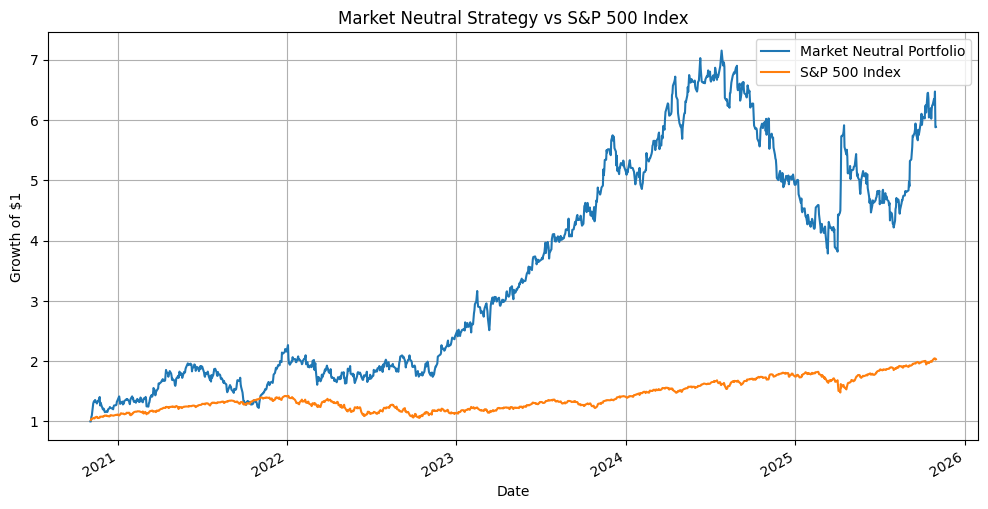

In [13]:
# Results DataFrame
results = returns.copy()
results['PortfolioReturn'] = daily_portfolio_returns
results['CumulativeReturn'] = (1 + results['PortfolioReturn']).cumprod()

# SP500 Index Download
sp500 = download_yfinance('^GSPC')
sp500 = sp500.set_index('Date')['Close']
sp500 = sp500.loc[results['CumulativeReturn'].index]  # Align dates
sp500_ret = sp500.pct_change().dropna()
sp500_cum_ret = (1 + sp500_ret).cumprod()



def count_outperformance_days(strategy_curve, benchmark_curve):
    # Align indices so both Series have identical dates
    merged = pd.DataFrame({'strat': strategy_curve, 'bench': benchmark_curve}).dropna()
    comparison = merged['strat'] > merged['bench']
    days_outperformed = comparison.sum()
    percent_outperformed = 100 * days_outperformed / len(comparison)
    print("")
    print(f"Days strategy beats SP500: {days_outperformed} out of {len(comparison)} ({percent_outperformed:.2f}%)")
    print("")
    return days_outperformed, percent_outperformed

# Usage -- run after your plotting code
days, percent = count_outperformance_days(results['CumulativeReturn'], sp500_cum_ret)

# Plot both series
plt.figure(figsize=(12, 6))
results['CumulativeReturn'].plot(label='Market Neutral Portfolio')
sharpe = ((results['PortfolioReturn'].mean()*252 -0.04) ) / (results['PortfolioReturn'].std() * np.sqrt(252))
print(f"Sharpe Ratio: {sharpe:.2f}")
print(results['CumulativeReturn'].describe())
sp500_cum_ret.plot(label='S&P 500 Index')
plt.title('Market Neutral Strategy vs S&P 500 Index')
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import pandas as pd

# Convert weights_list to DataFrame, aligning with your returns index and columns
weights_df = pd.DataFrame(weights_list, index=returns.index, columns=returns.columns)
weights_df.to_excel('weights_export.xlsx')

# Export the asset returns DataFrame as well
returns.to_excel('asset_returns_export.xlsx')
